In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.linalg import svd
import struct
import gzip
import os

In [16]:
def load_mnist(path="datasets/MNIST/raw"):
    for f in os.listdir(path):
        if 'train-images' in f:
            images = _load_images(os.path.join(path, f))
        elif 'train-labels' in f:
            labels = _load_labels(os.path.join(path, f))
    return images, labels


def _load_images(filepath):
    opener = gzip.open if filepath.endswith('.gz') else open
    with opener(filepath, 'rb') as f:
        f.read(4)
        n = struct.unpack('>I', f.read(4))[0]
        f.read(8)
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(n, 784).astype(np.float64)


def _load_labels(filepath):
    opener = gzip.open if filepath.endswith('.gz') else open
    with opener(filepath, 'rb') as f:
        f.read(8)
        return np.frombuffer(f.read(), dtype=np.uint8)


def group_by_class(features, labels):
    clusters = {}
    for k in range(10):
        clusters[k] = features[labels == k]
    return clusters


class MNISTBanditEnv:
    def __init__(self, clusters, target_class=0):
        self.clusters = clusters
        self.target_class = target_class
        self.K = 10
        self.d = 784
        self.reset()

    def reset(self):
        self.t = 0
        self.mistakes = 0
        self.cumulative_mistakes = []
        self.cumulative_regret = 0
        self.cumulative_regrets = []

    def get_contexts(self):
        contexts = np.zeros((self.K, self.d))
        for k in range(self.K):
            idx = np.random.randint(len(self.clusters[k]))
            contexts[k] = self.clusters[k][idx] #это перестановки
        return contexts

    def step(self, action):
        self.t += 1

        if action == self.target_class:
            reward = 1.0
        else:
            reward = 0.0
            self.mistakes += 1

        self.cumulative_mistakes.append(self.mistakes)
        return reward

In [4]:
# Load and normalize
images, labels = load_mnist("datasets/MNIST/raw")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)

print(features.shape)
print([len(clusters[k]) for k in range(10)])

(60000, 784)
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


In [17]:
class CBSCFD:
    def __init__(self, num_arms, lambd, beta, m, d):
        self.num_arms = num_arms
        self.d = d
        self.beta = beta
        self.alpha = lambd
        self.m = m

        self.theta = {a: np.zeros(self.d) for a in range(num_arms)}
        self.Z = {a: np.zeros((0, self.d)) for a in range(num_arms)}
        self.H = {a: None for a in range(num_arms)}
        self.H_prev = {a: None for a in range(num_arms)}
        self.sum_xy = {a: np.zeros(self.d) for a in range(num_arms)}
        self.alpha_per_arm = {a: lambd for a in range(num_arms)}
        self.t = 0

    def _apply_V_inv(self, x, a):
        if self.Z[a].shape[0] == 0:
            return x / self.alpha_per_arm[a]
        Zx = self.Z[a] @ x
        HZx = self.H[a] @ Zx
        ZT_HZx = self.Z[a].T @ HZx
        return (x - ZT_HZx) / self.alpha_per_arm[a]

    def update(self, user_context, a, r):
        self.t += 1
        x_t = user_context
        self.sum_xy[a] += x_t * r
        n_prev = self.Z[a].shape[0]
        self.Z[a] = np.vstack([self.Z[a], x_t.reshape(1, -1)])
        n = self.Z[a].shape[0]

        if n == 2 * self.m:
            self._svd_update(a)
        else:
            self._sequential_update(x_t, n_prev, a)

        self.theta[a] = self._apply_V_inv(self.sum_xy[a], a)

    def _svd_update(self, a):
        U, Sigma, Vt = svd(self.Z[a], full_matrices=False)
        if len(Sigma) >= self.m:
            delta_t = Sigma[self.m - 1] ** 2
        else:
            delta_t = 0
        self.alpha_per_arm[a] += delta_t
        Sigma_hat_sq = np.maximum(Sigma[:self.m] ** 2 - delta_t, 0)
        Sigma_hat = np.sqrt(Sigma_hat_sq)
        self.Z[a] = Sigma_hat.reshape(-1, 1) * Vt[:self.m, :]
        H_diag = 1.0 / (Sigma_hat_sq + self.alpha_per_arm[a])
        self.H[a] = np.diag(H_diag)
        self.H_prev[a] = self.H[a].copy()

    def _sequential_update(self, x_t, n_prev, a):
        n = self.Z[a].shape[0]
        if n == 1:
            k = np.dot(x_t, x_t) + self.alpha_per_arm[a]
            self.H[a] = np.array([[1.0 / k]])
            self.H_prev[a] = self.H[a]
        else:
            if self.H_prev[a] is None or self.H_prev[a].shape[0] != n_prev:
                self.H_prev[a] = np.eye(n_prev) / self.alpha_per_arm[a]
            Z_prev = self.Z[a][:n_prev, :]
            Z_prev_x = Z_prev @ x_t
            p = self.H_prev[a] @ Z_prev_x
            k_scalar = np.dot(x_t, x_t) - np.dot(Z_prev_x, p) + self.alpha_per_arm[a]
            self.H[a] = np.zeros((n, n))
            self.H[a][:n-1, :n-1] = self.H_prev[a] + np.outer(p, p) / k_scalar
            self.H[a][:n-1, n-1] = -p / k_scalar
            self.H[a][n-1, :n-1] = -p / k_scalar
            self.H[a][n-1, n-1] = 1.0 / k_scalar
            self.H_prev[a] = self.H[a]

    def score(self, user_context, arm):
        x = user_context
        mean = np.dot(self.theta[arm], x)
        var = np.dot(x, self._apply_V_inv(x, arm))
        return mean + self.beta * np.sqrt(max(var, 0))

In [18]:
def run_experiment(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)
    
    env = MNISTBanditEnv(clusters, target_class=0)
    bandit = CBSCFD(num_arms=10, lambd=lambd, beta=beta, m=m, d=784)
    
    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)
    
    return env.cumulative_mistakes

In [31]:
T = 4000
n_runs = 20
m = 10
lambd = 1
beta = 1

all_mistakes = []

for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes = run_experiment(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)

all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)

print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/20


100%|██████████| 4000/4000 [00:01<00:00, 3110.04it/s]



Run 2/20


100%|██████████| 4000/4000 [00:01<00:00, 3178.84it/s]



Run 3/20


100%|██████████| 4000/4000 [00:01<00:00, 3197.65it/s]



Run 4/20


100%|██████████| 4000/4000 [00:01<00:00, 3163.49it/s]



Run 5/20


100%|██████████| 4000/4000 [00:01<00:00, 3079.12it/s]



Run 6/20


100%|██████████| 4000/4000 [00:01<00:00, 3247.83it/s]



Run 7/20


100%|██████████| 4000/4000 [00:01<00:00, 2964.19it/s]



Run 8/20


100%|██████████| 4000/4000 [00:01<00:00, 3082.79it/s]



Run 9/20


100%|██████████| 4000/4000 [00:01<00:00, 3410.36it/s]



Run 10/20


100%|██████████| 4000/4000 [00:01<00:00, 3367.08it/s]



Run 11/20


100%|██████████| 4000/4000 [00:01<00:00, 3351.30it/s]



Run 12/20


100%|██████████| 4000/4000 [00:01<00:00, 3242.16it/s]



Run 13/20


100%|██████████| 4000/4000 [00:01<00:00, 3233.19it/s]



Run 14/20


100%|██████████| 4000/4000 [00:01<00:00, 3239.74it/s]



Run 15/20


100%|██████████| 4000/4000 [00:01<00:00, 3244.09it/s]



Run 16/20


100%|██████████| 4000/4000 [00:01<00:00, 3238.39it/s]



Run 17/20


100%|██████████| 4000/4000 [00:01<00:00, 3209.86it/s]



Run 18/20


100%|██████████| 4000/4000 [00:01<00:00, 3200.46it/s]



Run 19/20


100%|██████████| 4000/4000 [00:01<00:00, 3251.61it/s]



Run 20/20


100%|██████████| 4000/4000 [00:01<00:00, 2965.87it/s]

num mistakes 53.5


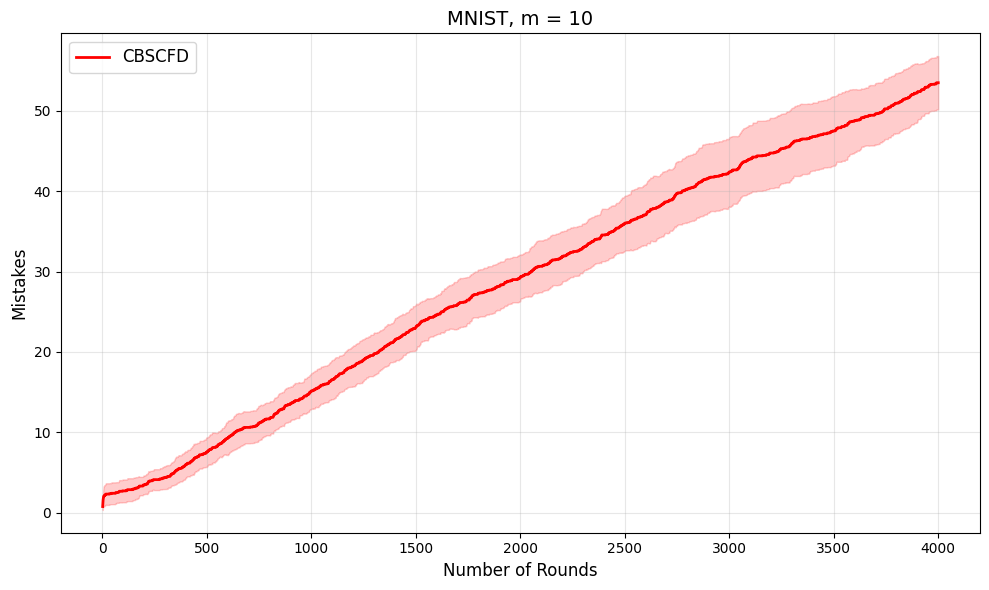

In [32]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='CBSCFD', color='red', linewidth=2)
plt.fill_between(rounds, 
                 mean_mistakes - std_mistakes, 
                 mean_mistakes + std_mistakes, 
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('MNIST, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()